In [ ]:
import re
import datetime
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

In [ ]:
import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Activation
# from keras.layers import Embedding
# from keras.layers import Bidirectional
# from keras.layers import Dropout
# from keras.layers import BatchNormalization

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('tagsets')

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

In [ ]:
from nltk.corpus import stopwords

In [ ]:
from keras.preprocessing.text import one_hot

In [ ]:
def lemmatize_phrase(phrase):
    # lemmatises words in a phrase, by considering their position and type
    # words such as 'swam' and 'swimming' are changed to 'swim'
    lemmatizer = WordNetLemmatizer()
    lemmatized_phrase = []

    for word, tag in pos_tag(word_tokenize(phrase)):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_phrase.append(lemmatizer.lemmatize(word, pos))

    return " ".join(lemmatized_phrase)

In [ ]:
os.mkdir('./sentiment-analysis-on-movie-reviews')

FileExistsError: ignored

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
gdd.download_file_from_google_drive(file_id='1o_vzk88Fu_n5R0NRAnpvKJOIQZY-QdqB',
                                    dest_path='./sentiment-analysis-on-movie-reviews/train.tsv',
                                    unzip=False)

gdd.download_file_from_google_drive(file_id='129VZS4q_WyJs9txnVzW85WDsCbOfbiXG',
                                    dest_path='./sentiment-analysis-on-movie-reviews/test.tsv',
                                    unzip=False)

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
#this includes negative words as well, which should be removed 

neg = ["aren't", "didn't", "don't", "doesn't", "hadn't",  "hasn't", "haven't", "isn't", "no", "not", "shouldn't", "wasn't", "weren't", "wouldn't", "couldn't",
      "aren", "didn", "don", "doesn", "hadn", "hasn", "haven", "isn", "shouldn", "wasn", "weren", "wouldn", "couldn",
       "mightn't", "mightn", "mustn't", "mustn", "needn't", "needn", "shan't", "shan", "won't", "won"]

# neg = ['no', 'not', "aren", "didn", "doesn", "hadn",  "haven", "isn", "shouldn", "wasn", "weren", "wouldn"]

# due to the way the text is cleaned up, words like don't and haven't appear as don and haven.

stop_words.difference_update(neg)

# stop_words.difference_update(['no', 'not'])

# stop_words

In [ ]:
# returns text -> rename function

def text_cleaning(text):
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/', ' ', text)
        text = re.sub(r'\\', ' ', text)
        text = re.sub(r'((http)\S+)', '', text)
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        
        text_final = [word for word in text.split() if word not in stop_words]

        if len(text_final) == 0:       # if all words are irrelevant, we may still wish to include the phrase
            text_final = [word for word in text.split()]
        return " ".join(text_final)
    return ""

In [ ]:
data_dir_train = './sentiment-analysis-on-movie-reviews/train.tsv'
data_dir_test = './sentiment-analysis-on-movie-reviews/test.tsv'

data_train = pd.read_csv(data_dir_train, sep='\t')
data_test = pd.read_csv(data_dir_test, sep='\t')

In [ ]:
data_train.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
# clean dataframes:
data_train['Phrase'] = data_train['Phrase'].apply(lambda x: text_cleaning(x))
data_test['Phrase'] = data_test['Phrase'].apply(lambda x: text_cleaning(x))

In [ ]:
# lemmatize data:
# lemmatises words in a phrase, by considering their position and type
# words such as 'swam' and 'swimming' are changed to 'swim'
lemmatize = False

if lemmatize:
    data_train['Phrase'] = data_train['Phrase'].apply(lambda x: lemmatize_phrase(x))
    data_test['Phrase'] = data_test['Phrase'].apply(lambda x: lemmatize_phrase(x))


In [ ]:
#drop duplicates from train

data_train.drop_duplicates(subset = ['Phrase'], inplace = True)
data_train.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,a,2
5,6,1,escapades demonstrating adage good goose,2


In [ ]:
# length column, explain why it's important

data_train['Length'] = data_train['Phrase'].apply(lambda x: len(x.split()))
data_test['Length'] = data_test['Phrase'].apply(lambda x: len(x.split()))

In [ ]:
maxlen = 200

In [ ]:
validation_split = 0.15
test_split = 0.15

x_train, x_test, y_train, y_test = train_test_split(
    data_train[data_train['Length']>0]['Phrase'],
    data_train[data_train['Length']>0]['Sentiment'],
    test_size = test_split,
    stratify = data_train[data_train['Length'] > 0]['Sentiment'],
    random_state = 40)

x_train, x_validation, y_train, y_validation = train_test_split(
    x_train,
    y_train,
    test_size = validation_split,
    stratify = y_train,
    random_state = 40)

# ('Length']>0 filters out 'empty' phrases, which were previously punctuation marks)

In [ ]:
vocab_size = 20000

encodings_train = x_train.apply(lambda z: one_hot(z, vocab_size))
encodings_validation = x_validation.apply(lambda z: one_hot(z, vocab_size))
encodings_test = x_test.apply(lambda z: one_hot(z, vocab_size))

In [ ]:
max_len_in_train = len(max(encodings_train, key = lambda i: len(i)))
max_len_in_validation = len(max(encodings_validation, key = lambda i: len(i)))
max_len_in_test = len(max(encodings_test, key = lambda i: len(i)))
max_len_in_dataset = max(max_len_in_train, max_len_in_validation, max_len_in_test)

if max_len_in_dataset < maxlen:
    maxlen = max_len_in_dataset

In [ ]:
encodings_train = keras.preprocessing.sequence.pad_sequences(encodings_train, maxlen=maxlen)
encodings_validation = keras.preprocessing.sequence.pad_sequences(encodings_validation, maxlen=maxlen)
encodings_test = keras.preprocessing.sequence.pad_sequences(encodings_test, maxlen=maxlen)

In [ ]:
model = keras.models.load_model('lstm-2-apr-b512-dropout0-2-bn-dim128-emb-untr-epochs-335-2-layer-ttv-final.h5')

#Confusion Matrix

In [ ]:
import time

In [ ]:
# inference on test dataset

test_st = time.time()
y_test_predicted_np = model.predict_on_batch(encodings_test)  # numpy array

test_tot = time.time() - test_st

In [ ]:
def get_prediction(arr):
      return arr.argmax()

In [ ]:
y_test_predicted = np.apply_along_axis(get_prediction, 1, y_test_predicted_np)

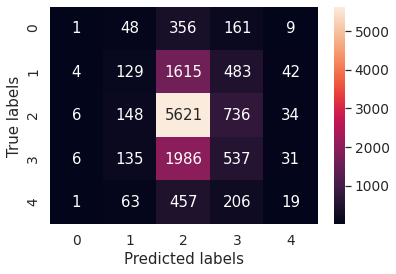

In [ ]:
import seaborn as sns

filename = 'conf_matrix_final.png'
sns.set(font_scale=1.25)

conf_matrix = confusion_matrix(y_test, y_test_predicted)
fig = sns.heatmap(conf_matrix, annot=True, fmt='g')
fig.set(xlabel = 'Predicted labels', ylabel = 'True labels')

plt.show()
figure = fig.get_figure()    
figure.savefig(filename, dpi=400)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_test_predicted)

0.4914290166744585